In [1]:
# Initial imports
import pandas as pd
import hvplot.pandas
from sklearn.linear_model import LinearRegression
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns


train_path = 'Resources/train.csv'
test_path = 'Resources/test.csv'
trained_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


In [2]:
from pyspark.sql import SparkSession
# Create a Spark session
spark = SparkSession.builder \
    .appName("YourAppNameHere") \
    .getOrCreate()

# Load the training and test data as Spark DataFrames
train_path = 'Resources/train.csv'
test_path = 'Resources/test.csv'

# You can specify the format and options if needed
train_data = spark.read.csv(train_path, header=True, inferSchema=True)
tested_data = spark.read.csv(test_path, header=True, inferSchema=True)

# You can perform various Spark operations on these DataFrames
# For example, to display the first few rows of the training data
train_data.show()



+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [3]:
tested_data.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgTy

In [4]:
print(trained_data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
trained_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
columns_to_remove = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType', 'Alley']

In [7]:
X = trained_data.copy()
X = X.loc[(X['YrSold'] >= 2006) & (X['YrSold'] <= 2010)] #not necessary, the dataset is already 2006-2010
X.drop(columns=columns_to_remove, inplace=True, axis=1)
Xf = X.dropna()
Xf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [8]:
dummies = pd.get_dummies(Xf, columns=['MSZoning','LotConfig','LotFrontage','Street','LotShape','LandContour',
                       'Utilities','LandContour','LandSlope','Neighborhood',
                       'Condition1','Condition2','BldgType','HouseStyle','SaleType','RoofStyle',
                      'RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                        'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual',
                 'Functional','GarageType','GarageFinish','GarageQual',
                  'GarageCond','PavedDrive','SaleType','SaleCondition'], dtype=float)
dummies

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,1457,20,13175,6,6,1978,1988,119.0,790,163,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,1458,70,9042,7,9,1941,2006,0.0,275,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# Define target vector
y = Xf["SalePrice"].ravel()
y[:5]

array([208500, 181500, 223500, 140000, 250000], dtype=int64)

In [10]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(dummies, y, random_state=78)


In [11]:
# Create the StandardScaler instance
scaler = StandardScaler()


In [12]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)


In [13]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [14]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78) #500 decision trees putting a vote
rf_model

RandomForestClassifier(n_estimators=500, random_state=78)

In [15]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [16]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [17]:
# Get the feature importance array
importances = rf_model.feature_importances_

In [18]:
# List the top 10 most important features
sorted(zip(rf_model.feature_importances_, X.columns[1:31]), reverse=True)

[(0.025706363360004723, 'MSSubClass'),
 (0.024825549011448865, 'OverallQual'),
 (0.02437659956591732, 'Foundation'),
 (0.024210708923580435, 'Condition2'),
 (0.02376271606316851, 'LotFrontage'),
 (0.023164891970868382, 'Condition1'),
 (0.0230456082757239, 'Neighborhood'),
 (0.020744002930578688, 'ExterQual'),
 (0.02022417635358984, 'LotShape'),
 (0.020011099896513982, 'LandContour'),
 (0.019103574035868726, 'LotConfig'),
 (0.017083688488116033, 'BsmtCond'),
 (0.01584390352205448, 'BsmtQual'),
 (0.015106243096804224, 'Exterior2nd'),
 (0.014203415593575826, 'Utilities'),
 (0.014095449794237401, 'BldgType'),
 (0.01265088365141831, 'LotArea'),
 (0.01018537779363353, 'RoofMatl'),
 (0.010012557293500706, 'MSZoning'),
 (0.009897688913151799, 'Street'),
 (0.008853728614390181, 'MasVnrArea'),
 (0.007464253352539215, 'OverallCond'),
 (0.006607740379641935, 'ExterCond'),
 (0.00629223939529302, 'BsmtExposure'),
 (0.006069366794839063, 'RoofStyle'),
 (0.0055053285308174745, 'YearRemodAdd'),
 (0.005

In [19]:
trained_data_sorted = trained_data.sort_values(by="MSSubClass", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="MSSubClass",
    y="SalePrice",
    title="Home Sale Price Based on Building Type"
)
home_sale_plot


:Bars   [MSSubClass]   (SalePrice)

In [20]:
trained_data_sorted = trained_data.sort_values(by="OverallQual", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="OverallQual",
    y="SalePrice",
    title="Home Sale Price Based on Overall Quality"
)
home_sale_plot


:Bars   [OverallQual]   (SalePrice)

In [21]:
trained_data_sorted = trained_data.sort_values(by="Foundation", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Foundation",
    y="SalePrice",
    title="Home Sale Price Based on Foundation"
)
home_sale_plot


:Bars   [Foundation]   (SalePrice)

In [22]:
trained_data_sorted = trained_data.sort_values(by="Condition2", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Condition2",
    y="SalePrice",
    title="Home Sale Price Based on Proximity to various conditions"
)
home_sale_plot


:Bars   [Condition2]   (SalePrice)

In [23]:
trained_data_sorted = trained_data.sort_values(by="LotFrontage", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.scatter(
    x="LotFrontage",
    y="SalePrice",
    title="Home Sale Price Based on Lot"
)
home_sale_plot


:Scatter   [LotFrontage]   (SalePrice)

In [24]:
trained_data_sorted = trained_data.sort_values(by="Condition1", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Condition1",
    y="SalePrice",
    title="Home Sale Price Based on proxmity to main road or railroad"
)
home_sale_plot

#condition 1 and 2 are together basically

:Bars   [Condition1]   (SalePrice)

In [25]:
trained_data_sorted = trained_data.sort_values(by="Neighborhood", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Neighborhood",
    y="SalePrice",
    title="Home Sale Price Based on Neighborhood",
)
home_sale_plot.opts(xrotation=45)

home_sale_plot



:Bars   [Neighborhood]   (SalePrice)

In [26]:
trained_data_sorted = trained_data.sort_values(by="ExterQual", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="ExterQual",
    y="SalePrice",
    title="Home Sale Price Based on Exterior Quality",
)

home_sale_plot


:Bars   [ExterQual]   (SalePrice)

In [27]:
trained_data_sorted = trained_data.sort_values(by="LotShape", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="LotShape",
    y="SalePrice",
    title="Home Sale Price Based on Shape of Property",
)

home_sale_plot


:Bars   [LotShape]   (SalePrice)

In [28]:
trained_data_sorted = trained_data.sort_values(by="LandContour", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="LandContour",
    y="SalePrice",
    title="Home Sale Price Based on Flatness of property",
)

home_sale_plot


:Bars   [LandContour]   (SalePrice)

In [29]:
trained_data_sorted = trained_data.sort_values(by="Heating", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Heating",
    y="SalePrice",
    title="Home Sale Price Based on Heating type",
)

home_sale_plot


:Bars   [Heating]   (SalePrice)

<Axes: xlabel='SalePrice', ylabel='Count'>

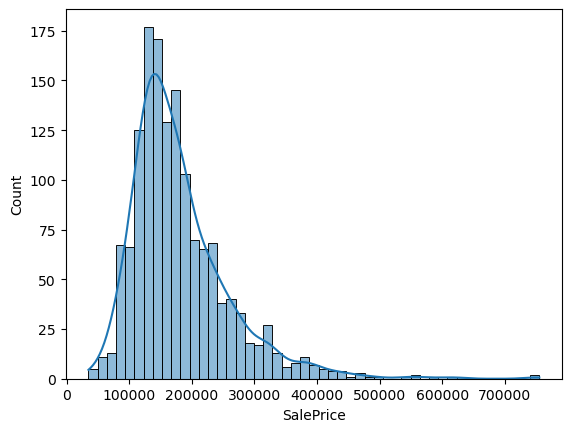

In [32]:
sns.histplot(trained_data['SalePrice'],kde=True)


<Axes: xlabel='SalePrice', ylabel='Count'>

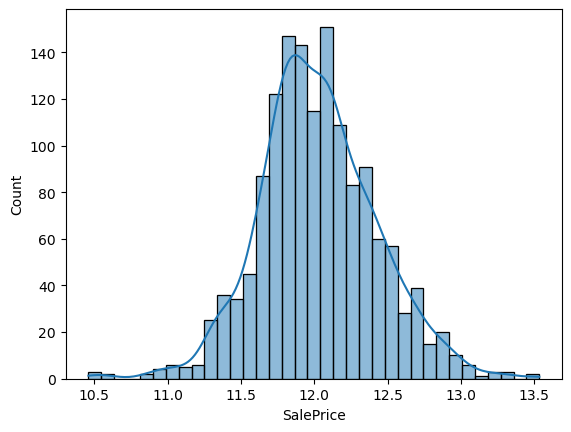

In [33]:
trained_data['SalePrice'] = np.log1p(trained_data['SalePrice'])
sns.histplot(trained_data['SalePrice'],kde=True)

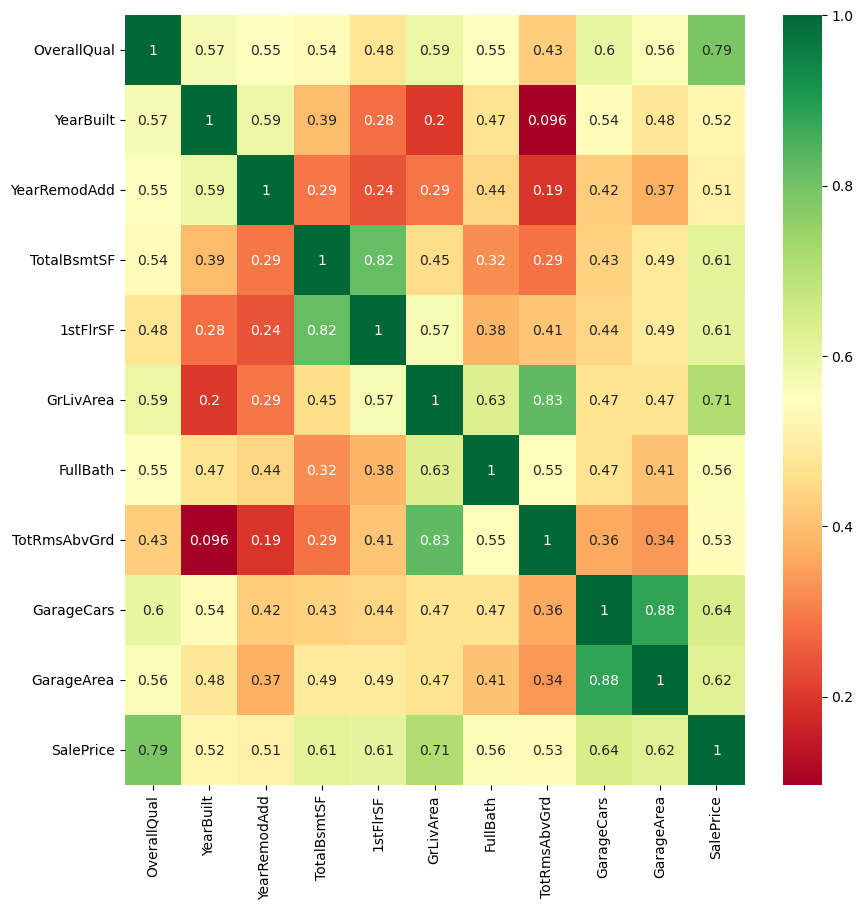

In [2]:
selected_columns = [
    "OverallQual", "YearBuilt", "YearRemodAdd", "TotalBsmtSF",
    "1stFlrSF", "GrLivArea", "FullBath", "TotRmsAbvGrd",
    "GarageYrBlt", "GarageCars", "GarageArea", "SalePrice"
] #skipped all the categorical values, probably should keep those since this
#influences homesaleprice as shown in the top features
trained_data_corr = trained_data[selected_columns]
corr = trained_data_corr.corr()
highly_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
map = sns.heatmap(trained_data[highly_corr_features].corr(),annot=True,cmap="RdYlGn")

In [3]:
corr["SalePrice"].sort_values(ascending=False).head(10)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

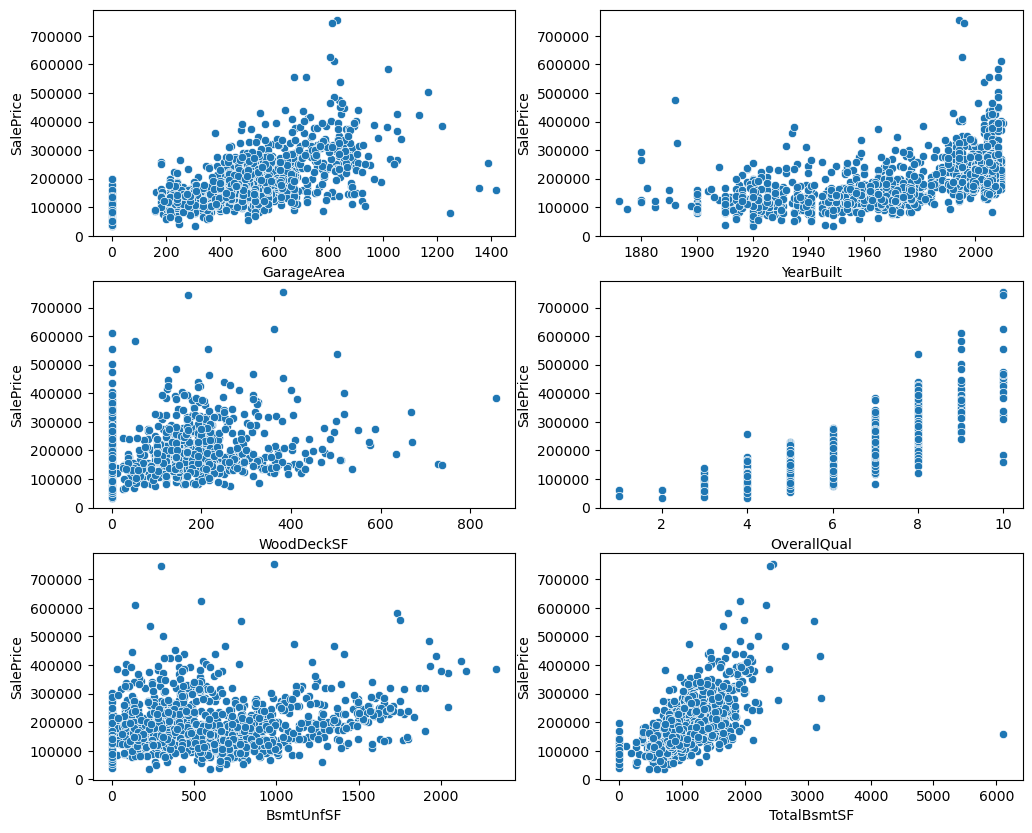

In [4]:
fig = plt.figure(figsize=(12,10))
#GarageArea
plt.subplot(321)
sns.scatterplot(data=trained_data, x='GarageArea', y="SalePrice")
#YearBuilt
plt.subplot(322)
sns.scatterplot(data=trained_data, x='YearBuilt', y="SalePrice")
#WoodDeckSF
plt.subplot(323)
sns.scatterplot(data=trained_data, x='WoodDeckSF', y="SalePrice")
#OverallQual
plt.subplot(324)
sns.scatterplot(data=trained_data, x='OverallQual', y="SalePrice")
#BsmtUnfSF
plt.subplot(325)
sns.scatterplot(data=trained_data, x='BsmtUnfSF', y="SalePrice")
#TotalBsmtSF
plt.subplot(326)
sns.scatterplot(data=trained_data, x='TotalBsmtSF', y="SalePrice")

In [5]:
data = pd.concat([trained_data,test_data], axis=0)
y_train = trained_data['SalePrice']
data = data.drop(['Id', 'SalePrice'], axis=1)
print(data.shape)
print('----------------------------------------------------------------')
print(data.info())

(2919, 79)
----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-n

In [6]:
#Columns containing most null values
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))

              Total    Percent
PoolQC         2909  99.657417
MiscFeature    2814  96.402878
Alley          2721  93.216855
Fence          2348  80.438506
MasVnrType     1766  60.500171
FireplaceQu    1420  48.646797
LotFrontage     486  16.649538
GarageYrBlt     159   5.447071
GarageFinish    159   5.447071
GarageQual      159   5.447071


In [7]:
#Dropping columns with > 5 null values
data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
#Sorting columns w.r.t null values
total = data.isnull().sum().sort_values(ascending=False)
total.head(20)

MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
BsmtFinSF2      1
Exterior2nd     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Electrical      1
SaleType        1
KitchenQual     1
HalfBath        0
FullBath        0
BedroomAbvGr    0
KitchenAbvGr    0
dtype: int64

In [8]:
#Filling the numeric data
numeric_missed = ['BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'BsmtFullBath',
'BsmtHalfBath',
'GarageArea',
'GarageCars']
for feature in numeric_missed:
    data[feature] = data[feature].fillna(0)
#Filling the categorical data
categorical_missed = ['Exterior1st',
'Exterior2nd',
'SaleType',
'MSZoning',
'Electrical',
'KitchenQual',
'Functional']
for feature in categorical_missed:
    data[feature] = data[feature].fillna(data[feature].mode()[0])
#Deleting 'Utilities' column
data.drop(['Utilities'], axis=1, inplace=True)

In [9]:
#Checking for any remaining null values
data.isnull().sum().max()

0

In [10]:
#Top skewed columns
numeric_features = data.dtypes[data.dtypes != 'object'].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
print(high_skew)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64


In [11]:
#Transforming skewed columns
for feature in high_skew.index:
    data[feature] = np.log1p(data[feature])
    
#Converting categorical data to numerical
data = pd.get_dummies(data)
data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,...,False,False,False,True,False,False,False,False,True,False
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,...,False,False,False,True,False,False,False,False,True,False
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,...,False,False,False,True,False,False,False,False,True,False
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,...,False,False,False,True,True,False,False,False,False,False
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,...,False,False,False,True,False,False,False,False,True,False


In [12]:
#Dividing data back into train & test
train=data[:len(y_train)]
test = data[len(y_train):]
#Printing thier shapes
print(train.shape, test.shape)

(1460, 218) (1459, 218)


In [13]:
x_train, x_test, y_train, y_test = train_test_split(train, y_train, test_size=0.2, random_state=42)


In [14]:
clf = RandomForestRegressor(n_estimators=300)
clf.fit(x_train, y_train)
clf.score(x_test,y_test)


0.8975667195228597

In [15]:
trained_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [18]:
#Making an prediction
prediction = clf.predict(trained_data)
print(prediction)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Alley
- BldgType
- BsmtCond
- BsmtExposure
- BsmtFinType1
- ...
Feature names seen at fit time, yet now missing:
- BldgType_1Fam
- BldgType_2fmCon
- BldgType_Duplex
- BldgType_Twnhs
- BldgType_TwnhsE
- ...
